Length of Ciphertext: 112965
Input image graph


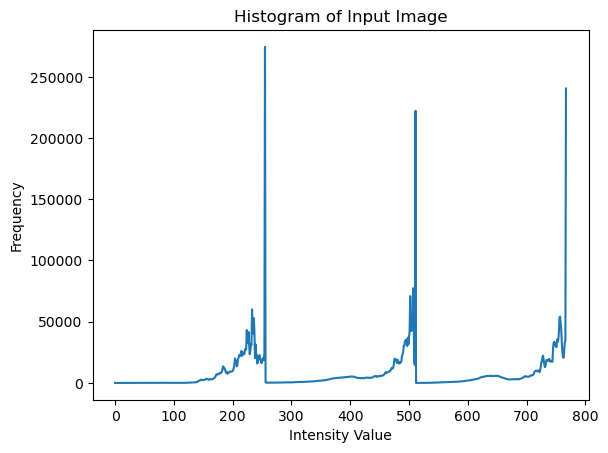

Length of Ciphertext(HEX):304672
Length of Ciphertext:152336
Keys & IV: 
The image has been encrypted successfully!


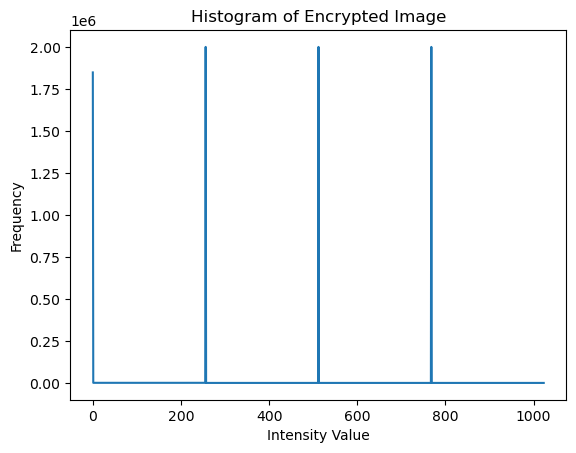

In [2]:
from Crypto.Cipher import Blowfish, PKCS1_OAEP, AES
from Crypto.PublicKey import RSA
from Crypto.Util.Padding import pad, unpad
from binascii import hexlify , unhexlify
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import io

with open("./test_files/flower.jpg","rb") as file:
    plaintext = file.read()


print("Length of Ciphertext: "+str(len(plaintext)))
print("Input image graph")
input_image = Image.open("./test_files/flower.jpg")
input_hist = input_image.histogram()
plt.title("Histogram of Input Image")
plt.xlabel("Intensity Value")
plt.ylabel("Frequency")
plt.plot(input_hist)
plt.show()

# Dictionary of Keys
keys_iv = {}

# Blowfish Layer 1

blowfish_key = 'my 16bit Blowfish key'.encode()
blowfish_cipher = Blowfish.new(blowfish_key, Blowfish.MODE_CBC)

blowfish_ciphertext = blowfish_cipher.encrypt(pad(plaintext, Blowfish.block_size ))

keys_iv['blowfish_iv'] = hexlify(blowfish_cipher.iv)
keys_iv['blowfish_key'] = hexlify(blowfish_key)

# RSA Layer 2

rsa_key = RSA.generate(2048)
rsa_private_key = rsa_key
rsa_public_key = rsa_key.publickey()

cipher_rsa = PKCS1_OAEP.new(rsa_public_key)
rsa_plaintext = blowfish_ciphertext

rsa_ciphertext = bytearray()
for i in range(0, len(rsa_plaintext), 190):
    rsa_ciphertext.extend(cipher_rsa.encrypt(rsa_plaintext[i:i+190]))

keys_iv['rsa_n'] = rsa_private_key.n
keys_iv['rsa_e'] = rsa_private_key.e
keys_iv['rsa_d'] = rsa_private_key.d

# AES Layer 3
aes_key = 'my 16bit AES key'.encode()
aes_cipher = AES.new(aes_key, AES.MODE_CBC)
aes_plaintext = rsa_ciphertext

aes_ciphertext = aes_cipher.encrypt(pad(aes_plaintext, AES.block_size))

ciphertext = aes_ciphertext

keys_iv['aes_iv'] = hexlify(aes_cipher.iv)
keys_iv['aes_key'] = hexlify(aes_key)

'''print("Ciphertext: " + ciphertext.hex())'''
print("Length of Ciphertext(HEX):"+str(len(ciphertext.hex())))
print("Length of Ciphertext:"+str(len(ciphertext)))
print("Keys & IV: ")

output_image = Image.new("RGBA", input_image.size)
output_image.putdata(list(zip(ciphertext)))
output_image.save("./test_files/encrypt2.png")
print("The image has been encrypted successfully!")

# Display the histogram of the output image
output_image = Image.open("./test_files/encrypt.png")
output_hist = output_image.histogram()
plt.title("Histogram of Encrypted Image")
plt.xlabel("Intensity Value")
plt.ylabel("Frequency")
plt.plot(output_hist)
plt.show()




112965
Image Decrypted succesfully


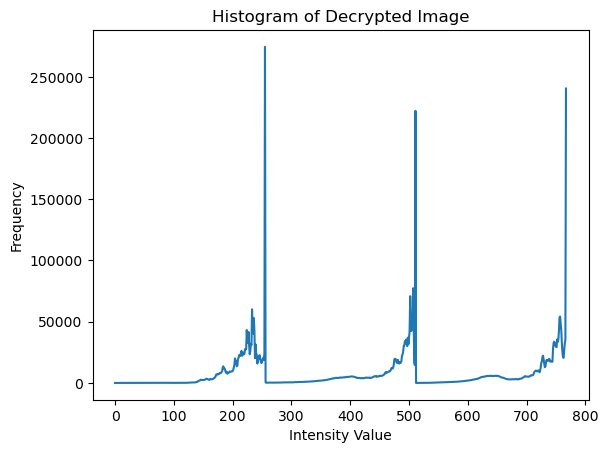

In [3]:
from PIL import Image
#Initializations

decryption_key_aes = unhexlify(keys_iv['aes_key'])
decryption_iv_aes = unhexlify(keys_iv['aes_iv'])
decryption_key_rsa = RSA.construct(rsa_components = (keys_iv['rsa_n'] , keys_iv['rsa_e'] , keys_iv['rsa_d']))
decryption_iv_blowfish = unhexlify(keys_iv['blowfish_iv'])
decryption_key_blowfish = unhexlify(keys_iv['blowfish_key'])


aes_cipher_decryption = AES.new(decryption_key_aes, AES.MODE_CBC, iv=decryption_iv_aes)
rsa_cipher_decryption = PKCS1_OAEP.new(decryption_key_rsa)
blowfish_cipher_decryption = Blowfish.new(decryption_key_blowfish, Blowfish.MODE_CBC, iv=decryption_iv_blowfish)

# AES DECRYPTION
ciphertext_rsa = unpad(aes_cipher_decryption.decrypt(ciphertext), AES.block_size)
# RSA DECRYPTION
ciphertext_blowfish = bytearray()
for i in range(0, len(ciphertext_rsa),256):
    ciphertext_rsa_segment = ciphertext_rsa[i:i+256]
    ciphertext_blowfish.extend(rsa_cipher_decryption.decrypt(ciphertext_rsa_segment))
    
# BLOWFISH DECRYPTION
decrypted_plaintext = unpad(blowfish_cipher_decryption.decrypt(ciphertext_blowfish), Blowfish.block_size)

print(len(decrypted_plaintext))
with open("./test_files/flower2.png","wb") as f:
    f.write(decrypted_plaintext)
print("Image Decrypted succesfully")
img = Image.open("./test_files/flower2.png")
decrypt_hist = img.histogram()
plt.title("Histogram of Decrypted Image")
plt.xlabel("Intensity Value")
plt.ylabel("Frequency")
plt.plot(decrypt_hist)
plt.show()